# Proyecto Final — Plan de Trabajo (DS_Telecom)

- **Estudiante**: Diana Andrea Carballo Sarabia
- **Bootcamp**: Data Scientist — TripleTen
- **Fecha**: [2025-11]
- **Sprint**: Proyecto Final — Etapa 1 (Plan de trabajo)


# Análisis Exploratorio de Datos (EDA)

## 1. Exploración inicial de cada dataset


 ## Importaciones y configuración

Lectura de archivos CSV desde `datasets/final_provider` usando rutas relativas.

In [ ]:
# Importaciones
from pathlib import Path
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 100)
RANDOM_STATE = 42

print("✅ Librerías cargadas. Versión de pandas:", pd.__version__)

In [ ]:
# Cargar todos los datasets (con validación de ruta)
from pathlib import Path

DATA_DIR = Path('./datasets/final_provider')
print('📁 DATA_DIR =', DATA_DIR.resolve())

assert DATA_DIR.exists(), f"No existe la carpeta de datos: {DATA_DIR}"

required_files = ['contract.csv', 'personal.csv', 'internet.csv', 'phone.csv']
missing = [f for f in required_files if not (DATA_DIR / f).exists()]
assert not missing, f"Faltan archivos: {missing}"

# Carga segura
contract_df = pd.read_csv(DATA_DIR / 'contract.csv')
personal_df = pd.read_csv(DATA_DIR / 'personal.csv')
internet_df = pd.read_csv(DATA_DIR / 'internet.csv')
phone_df = pd.read_csv(DATA_DIR / 'phone.csv')

print('✅ Datos cargados exitosamente')
print('\n📊 Dimensiones de los datasets:')
print(f"  - contract.csv: {contract_df.shape}")
print(f"  - personal.csv: {personal_df.shape}")
print(f"  - internet.csv: {internet_df.shape}")
print(f"  - phone.csv: {phone_df.shape}")

## Perfilado reutilizable de datasets

Para evitar repetir código del EDA en cada tabla, usaremos una función genérica de perfilado.

In [ ]:
# Función de perfilado genérico
from IPython.display import display

def profile_table(df, name: str, id_col: str = 'customerID', max_uniques: int = 10):
    print("="*60)
    print(f"DATASET: {name.upper()}")
    print("="*60)
    
    # Primeras filas
    print("\n📋 Primeras filas:")
    display(df.head())

    # Información general
    print("\n📊 Información general:")
    print(f"  - Filas: {df.shape[0]:,}")
    print(f"  - Columnas: {df.shape[1]}")
    if id_col in df.columns:
        print(f"  - Duplicados por {id_col}: {df[id_col].duplicated().sum()}")

    # Tipos de datos
    print("\n🔍 Tipos de datos:")
    print(df.dtypes)

    # Nulos
    print("\n❌ Valores nulos:")
    nulls = df.isnull().sum()
    print(nulls[nulls > 0] if nulls.sum() > 0 else "  No hay valores nulos")

    # Descriptivas numéricas
    num_cols = df.select_dtypes(include=[np.number]).columns
    if len(num_cols) > 0:
        print("\n📈 Estadísticas descriptivas (numéricas):")
        display(df[num_cols].describe())

    # Categóricas (top valores)
    cat_cols = [c for c in df.select_dtypes(include=['object']).columns if c != id_col]
    if len(cat_cols) > 0:
        print("\n🔤 Valores únicos por columna categórica (top):")
        for col in cat_cols:
            print(f"\n  {col}:")
            print(f"    Valores únicos: {df[col].nunique()}")
            print(f"    Distribución (top {max_uniques}):")
            display(df[col].value_counts().head(max_uniques))

# Uso sobre cada dataset
profile_table(contract_df, 'contract')
profile_table(personal_df, 'personal')
profile_table(internet_df, 'internet')
profile_table(phone_df, 'phone')

## Validación de duplicados e integridad de claves

In [ ]:
# Chequeos de duplicados e integridad de claves por customerID
from collections import OrderedDict

checks = OrderedDict()

# 1) Duplicados dentro de cada tabla
for name, df_ in {
    'contract': contract_df,
    'personal': personal_df,
    'internet': internet_df,
    'phone': phone_df
}.items():
    total = len(df_)
    uniq = df_['customerID'].nunique()
    dups = total - uniq
    dup_ids = (
        df_['customerID'][df_['customerID'].duplicated(keep=False)]
        .value_counts()
        .head(10)
        .index.tolist()
        if dups > 0 else []
    )
    checks[f'duplicados_{name}'] = {
        'filas': total,
        'customerID_unicos': uniq,
        'duplicados': dups,
        'ejemplos_customerID_duplicados': dup_ids
    }

# 2) Cobertura de claves vs contract (tabla base)
contract_ids = set(contract_df['customerID'])
for name, df_ in {'personal': personal_df, 'internet': internet_df, 'phone': phone_df}.items():
    other_ids = set(df_['customerID'])
    faltan_en_otro = len(contract_ids - other_ids)  # están en contract pero NO en la otra
    faltan_en_contract = len(other_ids - contract_ids)  # están en la otra pero NO en contract
    checks[f'cobertura_vs_contract__{name}'] = {
        'en_contract_no_en_otro': faltan_en_otro,
        'en_otro_no_en_contract': faltan_en_contract
    }

# 3) Reporte legible
print("="*60)
print("VALIDACIÓN DE DUPLICADOS E INTEGRIDAD DE CLAVES")
print("="*60)

for k, v in checks.items():
    print(f"\n>> {k}")
    for kk, vv in v.items():
        print(f"  - {kk}: {vv}")

# 4) Aserciones opcionales (comentar si el dataset permite 1:N)
# Se asume 1 fila por customerID en todas las tablas.
assert checks['duplicados_contract']['duplicados'] == 0, "Hay customerID duplicados en contract"
assert checks['duplicados_personal']['duplicados'] == 0, "Hay customerID duplicados en personal"
assert checks['duplicados_internet']['duplicados'] == 0, "Hay customerID duplicados en internet"
assert checks['duplicados_phone']['duplicados'] == 0, "Hay customerID duplicados en phone"

print("\n✅ Validación completada: no se encontraron duplicados por customerID.")

In [ ]:
# Saneamiento de tipos para columnas numéricas usadas en gráficos
# Asegurar que TotalCharges y MonthlyCharges sean numéricas

# TotalCharges puede venir como string; convertir a numérico con coerción
if df['TotalCharges'].dtype == 'object':
    before_na = df['TotalCharges'].isna().sum()
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'].str.strip(), errors='coerce')
    after_na = df['TotalCharges'].isna().sum()
    print(f"TotalCharges: convertidas a numérico. Nuevos NaN por coerción: {after_na - before_na}")

# MonthlyCharges debería ser numérica; forzar y reportar
if df['MonthlyCharges'].dtype == 'object':
    before_na = df['MonthlyCharges'].isna().sum()
    df['MonthlyCharges'] = pd.to_numeric(df['MonthlyCharges'].str.strip(), errors='coerce')
    after_na = df['MonthlyCharges'].isna().sum()
    print(f"MonthlyCharges: convertidas a numérico. Nuevos NaN por coerción: {after_na - before_na}")

# Verificar que hay datos suficientes para boxplots
for col in ['MonthlyCharges', 'TotalCharges']:
    counts = df.groupby('Churn')[col].apply(lambda s: s.dropna().shape[0])
    print(f"Filas válidas para {col} por Churn: {counts.to_dict()}")

## 2. Unión de datasets y creación del dataset principal


In [19]:
# Unir todos los datasets por customerID
print("=" * 60)
print("UNIÓN DE DATASETS")
print("=" * 60)

# Unir datasets usando left join desde contract (dataset principal)
df = contract_df.copy()

print(f"\n📊 Tamaño inicial (contract): {df.shape}")

# Unir con personal
df = df.merge(personal_df, on='customerID', how='left')
print(f"📊 Después de unir personal: {df.shape}")

# Unir con internet
df = df.merge(internet_df, on='customerID', how='left')
print(f"📊 Después de unir internet: {df.shape}")

# Unir con phone
df = df.merge(phone_df, on='customerID', how='left')
print(f"📊 Después de unir phone: {df.shape}")

print(f"\n✅ Dataset final: {df.shape[0]:,} filas × {df.shape[1]} columnas")

# Verificar valores nulos después de la unión
print("\n❌ Valores nulos después de la unión:")
nulls_after = df.isnull().sum()
nulls_after = nulls_after[nulls_after > 0]
if len(nulls_after) > 0:
    print(nulls_after)
else:
    print("  No hay valores nulos")

# imprmimir el dataset final
df.head()


UNIÓN DE DATASETS

📊 Tamaño inicial (contract): (7043, 8)
📊 Después de unir personal: (7043, 12)
📊 Después de unir internet: (7043, 19)
📊 Después de unir phone: (7043, 20)

✅ Dataset final: 7,043 filas × 20 columnas

❌ Valores nulos después de la unión:
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
dtype: int64


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


## 3. Análisis de la variable objetivo (Churn)

### 3.1 Definición de Churn


ANÁLISIS DE CHURN

📊 Distribución de Churn:
Churn
0    5174
1    1869
Name: count, dtype: int64

📈 Porcentajes:
  - Clientes activos (Churn=0): 5,174 (73.46%)
  - Clientes que cancelaron (Churn=1): 1,869 (26.54%)


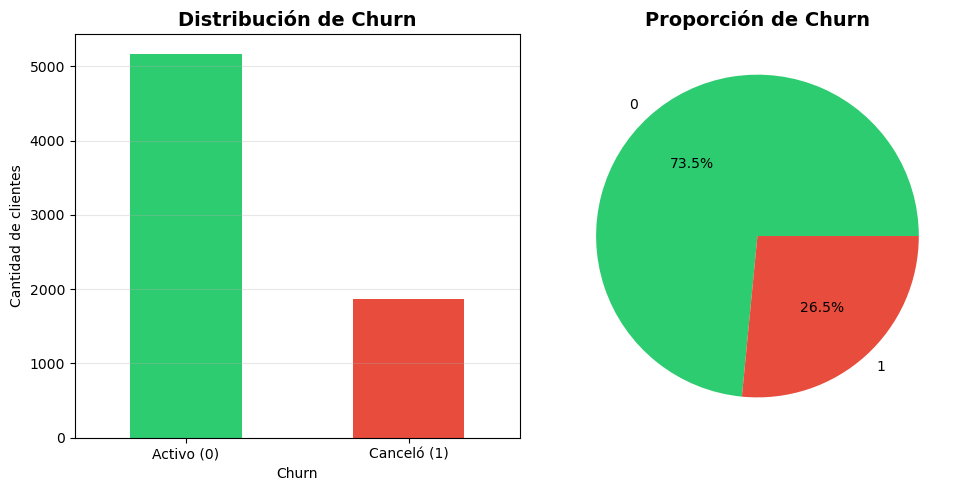


⚠️  NOTA: El dataset está DESBALANCEADO
   Ratio de desbalance: 2.77:1


In [20]:
# Crear variable objetivo Churn
# Churn = 1 si EndDate no es "No" (es decir, tiene una fecha de cancelación)
# Churn = 0 si EndDate es "No" (cliente activo)

df['Churn'] = (df['EndDate'] != 'No').astype(int)

print("=" * 60)
print("ANÁLISIS DE CHURN")
print("=" * 60)

print("\n📊 Distribución de Churn:")
churn_dist = df['Churn'].value_counts()
print(churn_dist)
print(f"\n📈 Porcentajes:")
print(f"  - Clientes activos (Churn=0): {churn_dist[0]:,} ({churn_dist[0]/len(df)*100:.2f}%)")
print(f"  - Clientes que cancelaron (Churn=1): {churn_dist[1]:,} ({churn_dist[1]/len(df)*100:.2f}%)")

# Visualización
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
churn_dist.plot(kind='bar', color=['#2ecc71', '#e74c3c'])
plt.title('Distribución de Churn', fontsize=14, fontweight='bold')
plt.xlabel('Churn')
plt.ylabel('Cantidad de clientes')
plt.xticks([0, 1], ['Activo (0)', 'Canceló (1)'], rotation=0)
plt.grid(axis='y', alpha=0.3)

plt.subplot(1, 2, 2)
churn_dist.plot(kind='pie', autopct='%1.1f%%', colors=['#2ecc71', '#e74c3c'])
plt.title('Proporción de Churn', fontsize=14, fontweight='bold')
plt.ylabel('')

plt.tight_layout()
plt.show()

print(f"\n⚠️  NOTA: El dataset está {'DESBALANCEADO' if abs(churn_dist[0] - churn_dist[1]) > len(df) * 0.2 else 'BALANCEADO'}")
print(f"   Ratio de desbalance: {churn_dist[0] / churn_dist[1]:.2f}:1")


## 4. Análisis de variables numéricas


VARIABLES NUMÉRICAS

📊 Variables numéricas: ['MonthlyCharges']

📈 Estadísticas descriptivas:


,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


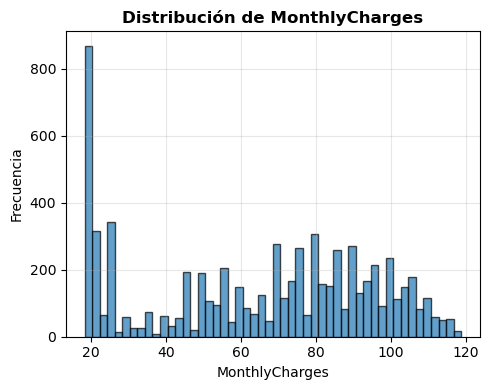


🔗 Correlación con Churn:
Churn             1.000000
MonthlyCharges    0.193356
Name: Churn, dtype: float64


In [21]:
# Análisis de variables numéricas
print("=" * 60)
print("VARIABLES NUMÉRICAS")
print("=" * 60)

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [col for col in numeric_cols if col not in ['Churn', 'SeniorCitizen']]

print(f"\n📊 Variables numéricas: {numeric_cols}")

print("\n📈 Estadísticas descriptivas:")
display(df[numeric_cols].describe())

# Visualización de distribuciones
fig, axes = plt.subplots(1, len(numeric_cols), figsize=(5*len(numeric_cols), 4))
if len(numeric_cols) == 1:
    axes = [axes]

for idx, col in enumerate(numeric_cols):
    axes[idx].hist(df[col].dropna(), bins=50, edgecolor='black', alpha=0.7)
    axes[idx].set_title(f'Distribución de {col}', fontweight='bold')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Frecuencia')
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Análisis de correlación con Churn
print("\n🔗 Correlación con Churn:")
correlations = df[numeric_cols + ['Churn']].corr()['Churn'].sort_values(ascending=False)
print(correlations)


### 4.1 Análisis de MonthlyCharges y TotalCharges por Churn


TypeError: ufunc 'divide' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

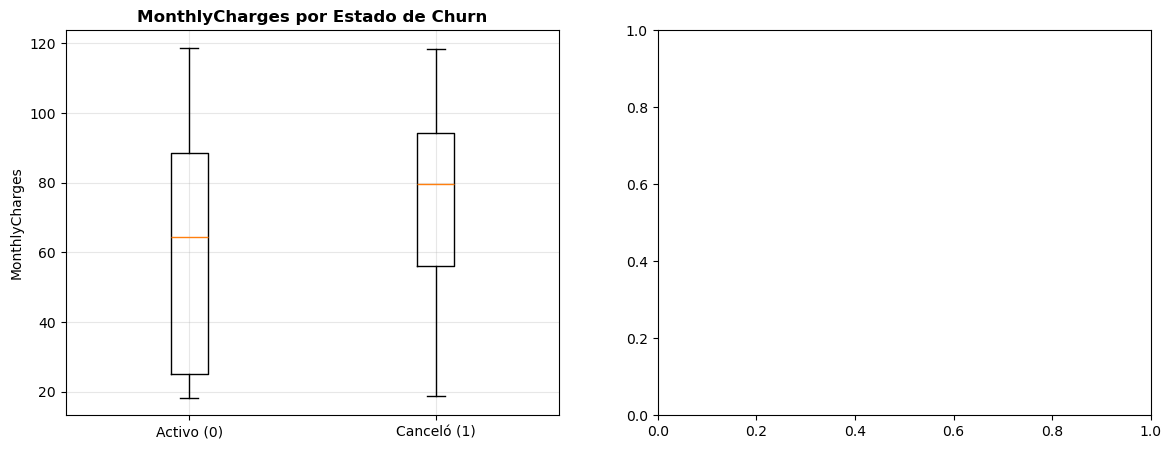

In [25]:
# Comparación de cargos entre clientes que cancelaron y activos
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# MonthlyCharges
axes[0].boxplot([df[df['Churn']==0]['MonthlyCharges'].dropna(), 
                 df[df['Churn']==1]['MonthlyCharges'].dropna()],
                labels=['Activo (0)', 'Canceló (1)'])
axes[0].set_title('MonthlyCharges por Estado de Churn', fontweight='bold')
axes[0].set_ylabel('MonthlyCharges')
axes[0].grid(alpha=0.3)

# TotalCharges
axes[1].boxplot([df[df['Churn']==0]['TotalCharges'].dropna(), 
                 df[df['Churn']==1]['TotalCharges'].dropna()],
                labels=['Activo (0)', 'Canceló (1)'])
axes[1].set_title('TotalCharges por Estado de Churn', fontweight='bold')
axes[1].set_ylabel('TotalCharges')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Estadísticas comparativas
print("\n📊 Estadísticas comparativas:")
print("\nMonthlyCharges:")
print(df.groupby('Churn')['MonthlyCharges'].describe())

print("\nTotalCharges:")
print(df.groupby('Churn')['TotalCharges'].describe())


## 5. Análisis de variables categóricas y su relación con Churn


VARIABLES CATEGÓRICAS Y CHURN

📊 Variables categóricas a analizar: 15
['Type', 'PaperlessBilling', 'PaymentMethod', 'TotalCharges', 'gender', 'Partner', 'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']

Variable: Type

📊 Tabla de contingencia:


Churn,0,1,All
Type,,,
Month-to-month,2220,1655,3875
One year,1307,166,1473
Two year,1647,48,1695
All,5174,1869,7043



📈 Tasa de Churn por categoría:


,Tasa_Churn,Cantidad
Type,,
Month-to-month,0.427097,3875
One year,0.112695,1473
Two year,0.028319,1695


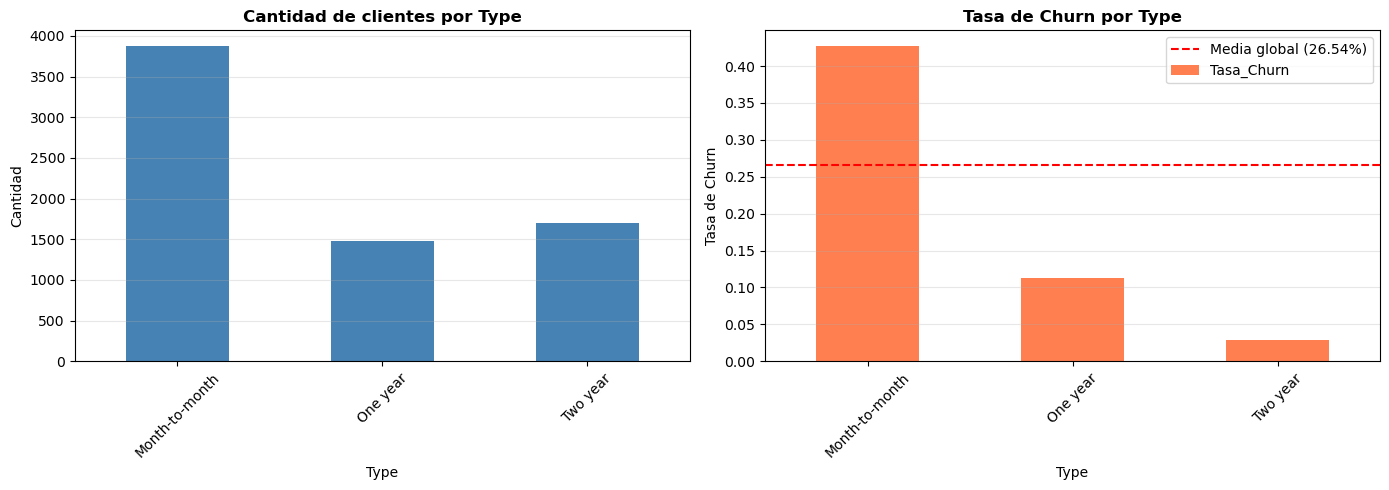


Variable: PaperlessBilling

📊 Tabla de contingencia:


Churn,0,1,All
PaperlessBilling,,,
No,2403,469,2872
Yes,2771,1400,4171
All,5174,1869,7043



📈 Tasa de Churn por categoría:


,Tasa_Churn,Cantidad
PaperlessBilling,,
Yes,0.335651,4171
No,0.163301,2872


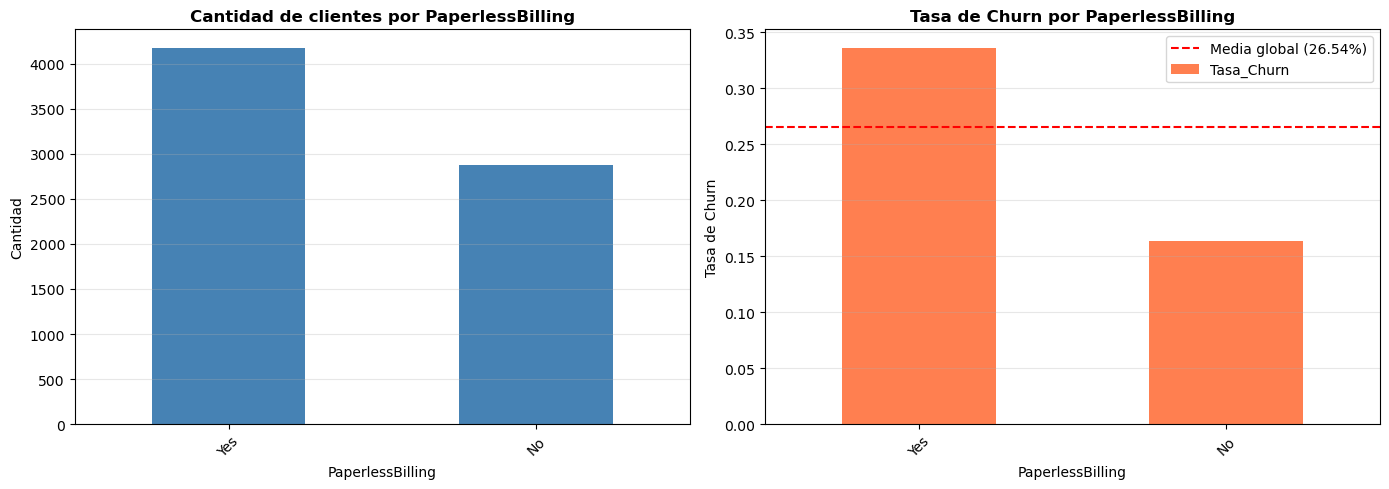


Variable: PaymentMethod

📊 Tabla de contingencia:


Churn,0,1,All
PaymentMethod,,,
Bank transfer (automatic),1286,258,1544
Credit card (automatic),1290,232,1522
Electronic check,1294,1071,2365
Mailed check,1304,308,1612
All,5174,1869,7043



📈 Tasa de Churn por categoría:


,Tasa_Churn,Cantidad
PaymentMethod,,
Electronic check,0.452854,2365
Mailed check,0.191067,1612
Bank transfer (automatic),0.167098,1544
Credit card (automatic),0.152431,1522


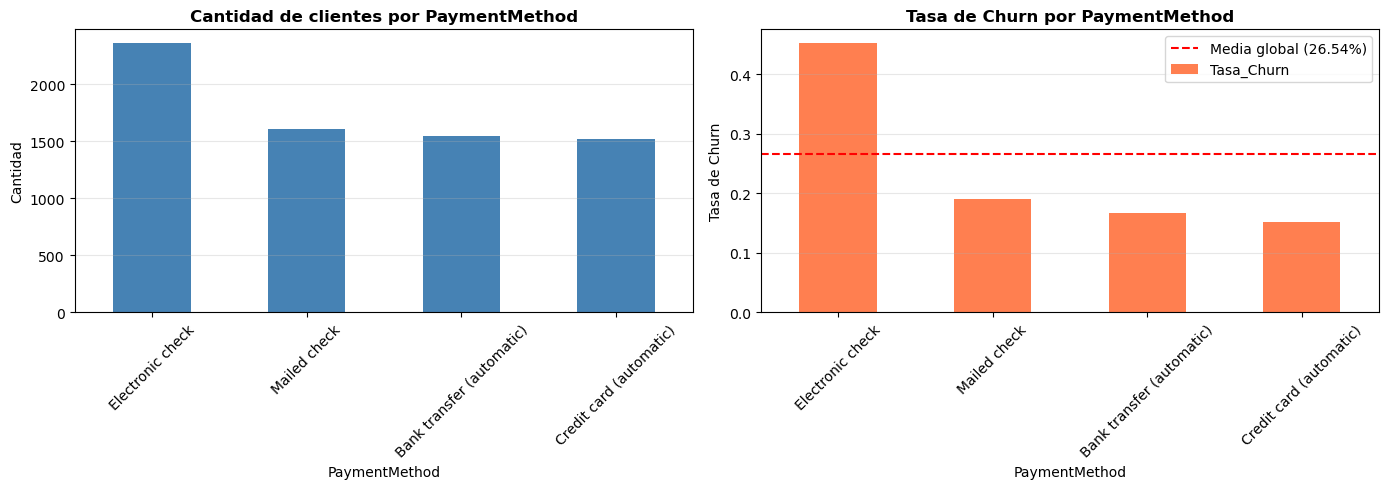


Variable: TotalCharges

📊 Tabla de contingencia:


Churn,0,1,All
TotalCharges,,,
,11,0,11
100.2,1,0,1
100.25,0,1,1
100.35,1,0,1
100.4,0,1,1
...,...,...,...
998.1,1,0,1
999.45,0,1,1
999.8,1,0,1



📈 Tasa de Churn por categoría:


,Tasa_Churn,Cantidad
TotalCharges,,
2812.2,1.0,1
872.65,1.0,1
990.85,1.0,1
1505.85,1.0,1
100.4,1.0,1
...,...,...
997.75,0.0,1
998.1,0.0,1
163.2,0.0,1



Variable: gender

📊 Tabla de contingencia:


Churn,0,1,All
gender,,,
Female,2549,939,3488
Male,2625,930,3555
All,5174,1869,7043



📈 Tasa de Churn por categoría:


,Tasa_Churn,Cantidad
gender,,
Female,0.269209,3488
Male,0.261603,3555


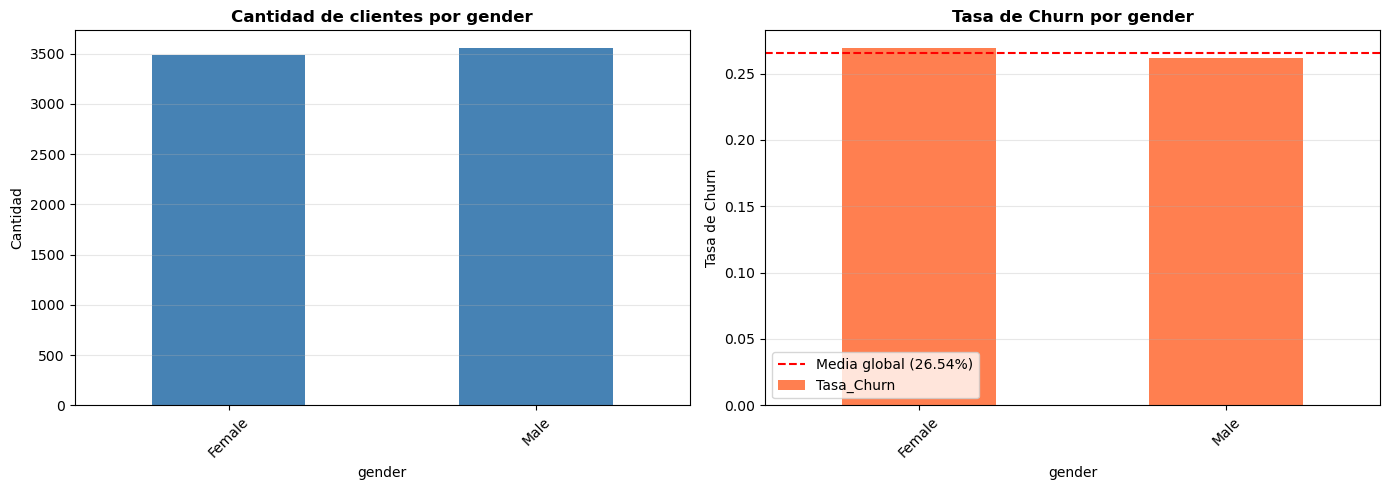


Variable: Partner

📊 Tabla de contingencia:


Churn,0,1,All
Partner,,,
No,2441,1200,3641
Yes,2733,669,3402
All,5174,1869,7043



📈 Tasa de Churn por categoría:


,Tasa_Churn,Cantidad
Partner,,
No,0.329580,3641
Yes,0.196649,3402


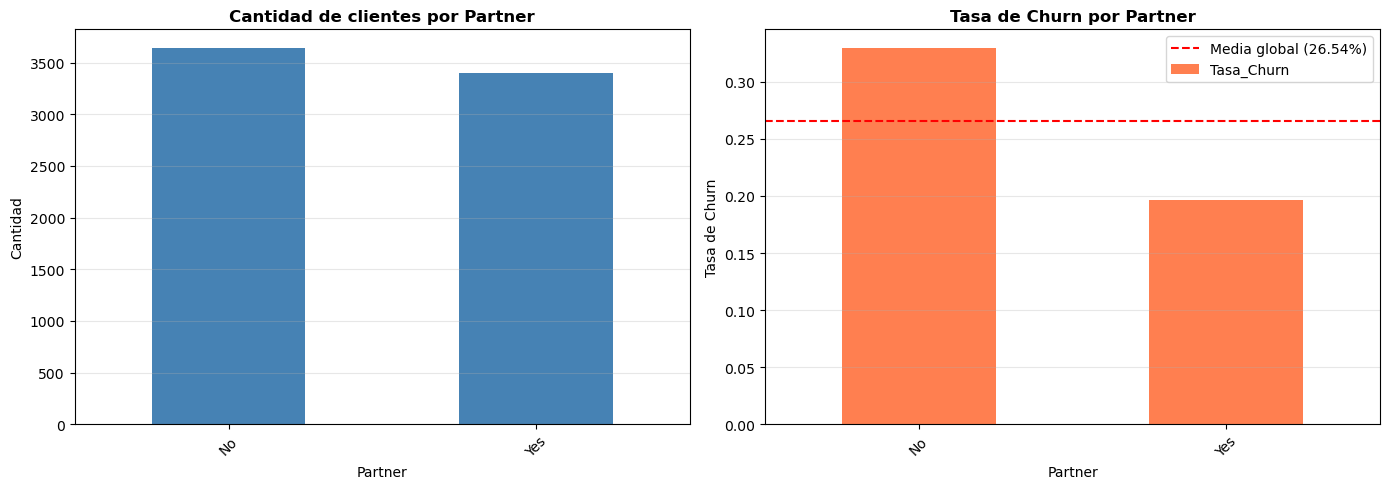


Variable: Dependents

📊 Tabla de contingencia:


Churn,0,1,All
Dependents,,,
No,3390,1543,4933
Yes,1784,326,2110
All,5174,1869,7043



📈 Tasa de Churn por categoría:


,Tasa_Churn,Cantidad
Dependents,,
No,0.312791,4933
Yes,0.154502,2110


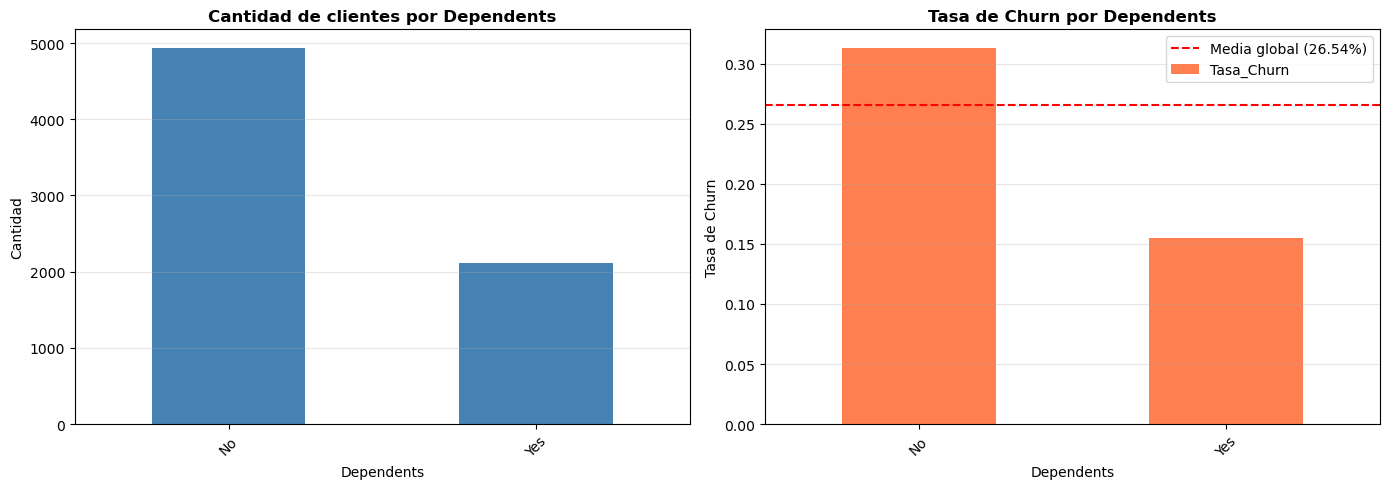


Variable: InternetService

📊 Tabla de contingencia:


Churn,0,1,All
InternetService,,,
DSL,1962,459,2421
Fiber optic,1799,1297,3096
All,3761,1756,5517



📈 Tasa de Churn por categoría:


,Tasa_Churn,Cantidad
InternetService,,
Fiber optic,0.418928,3096
DSL,0.189591,2421


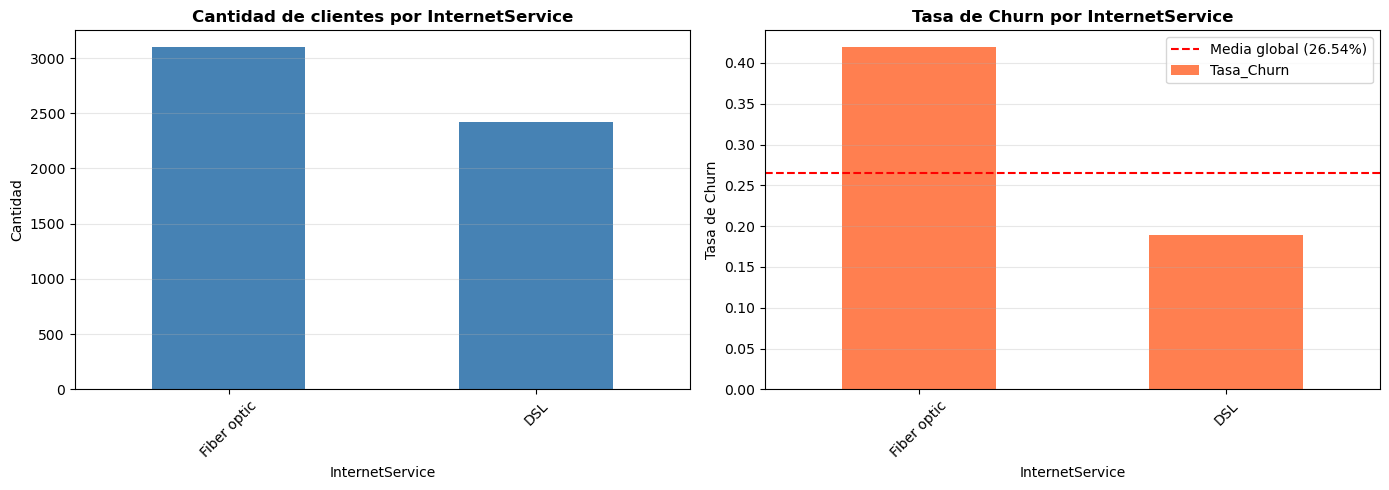


Variable: OnlineSecurity

📊 Tabla de contingencia:


Churn,0,1,All
OnlineSecurity,,,
No,2037,1461,3498
Yes,1724,295,2019
All,3761,1756,5517



📈 Tasa de Churn por categoría:


,Tasa_Churn,Cantidad
OnlineSecurity,,
No,0.417667,3498
Yes,0.146112,2019


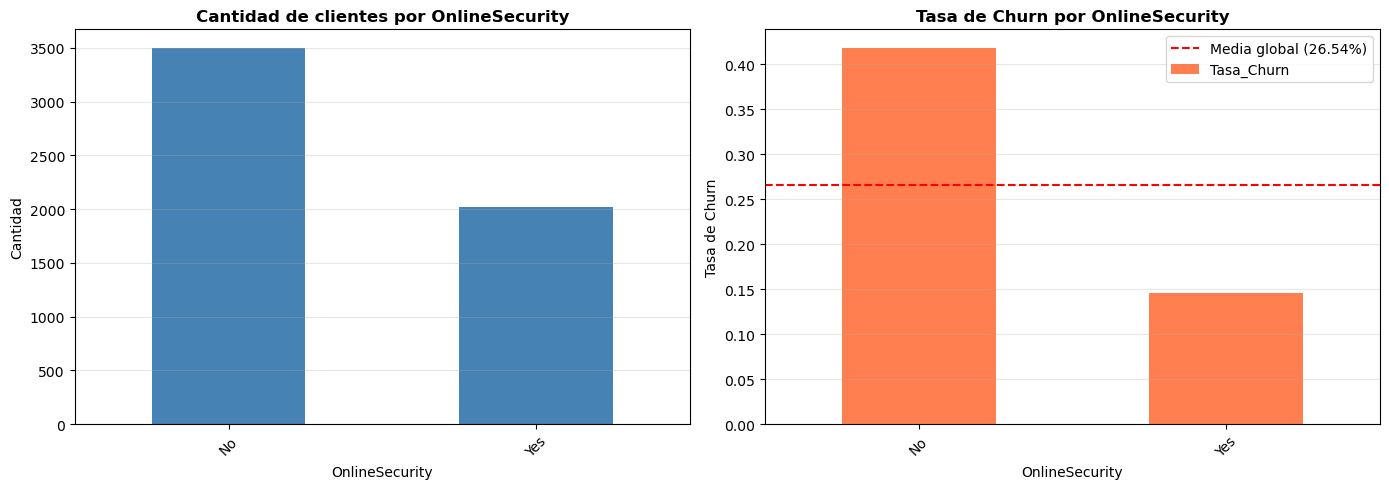


Variable: OnlineBackup

📊 Tabla de contingencia:


Churn,0,1,All
OnlineBackup,,,
No,1855,1233,3088
Yes,1906,523,2429
All,3761,1756,5517



📈 Tasa de Churn por categoría:


,Tasa_Churn,Cantidad
OnlineBackup,,
No,0.399288,3088
Yes,0.215315,2429


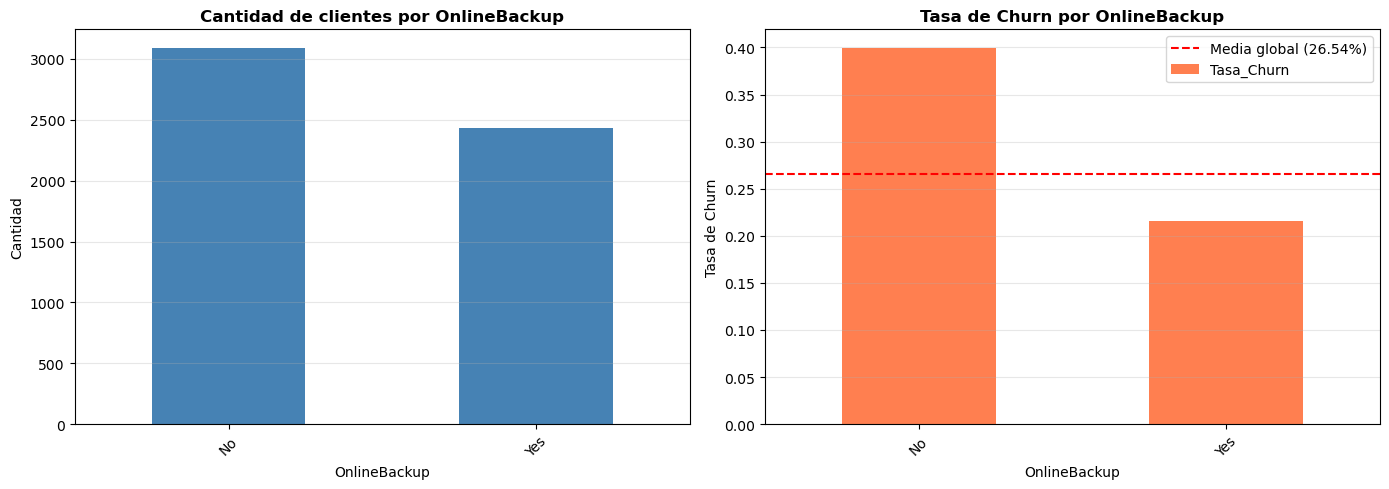


Variable: DeviceProtection

📊 Tabla de contingencia:


Churn,0,1,All
DeviceProtection,,,
No,1884,1211,3095
Yes,1877,545,2422
All,3761,1756,5517



📈 Tasa de Churn por categoría:


,Tasa_Churn,Cantidad
DeviceProtection,,
No,0.391276,3095
Yes,0.225021,2422


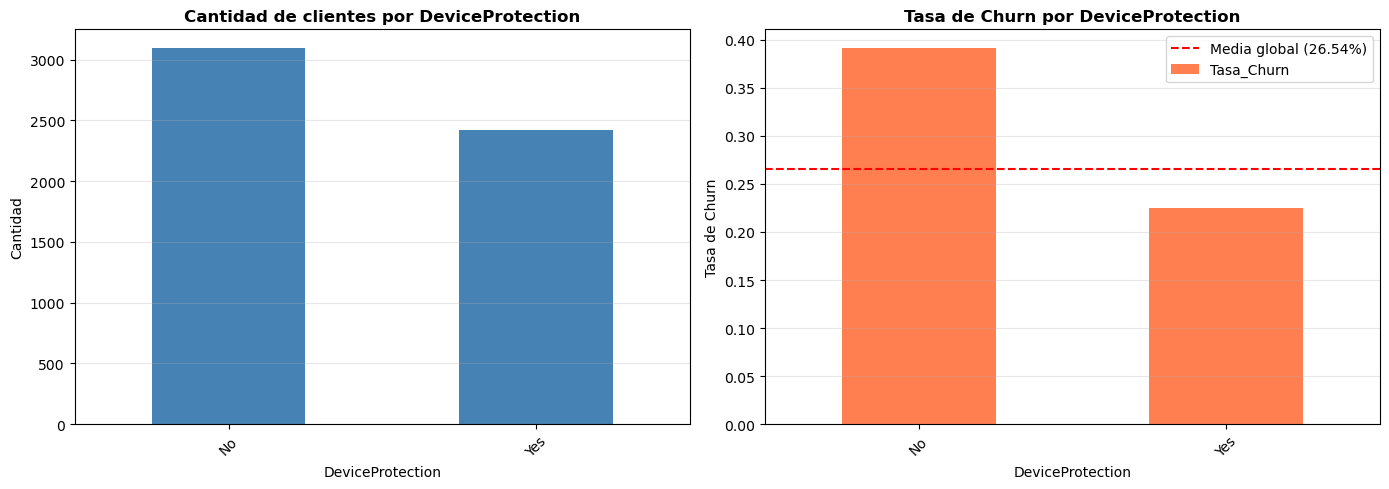


Variable: TechSupport

📊 Tabla de contingencia:


Churn,0,1,All
TechSupport,,,
No,2027,1446,3473
Yes,1734,310,2044
All,3761,1756,5517



📈 Tasa de Churn por categoría:


,Tasa_Churn,Cantidad
TechSupport,,
No,0.416355,3473
Yes,0.151663,2044


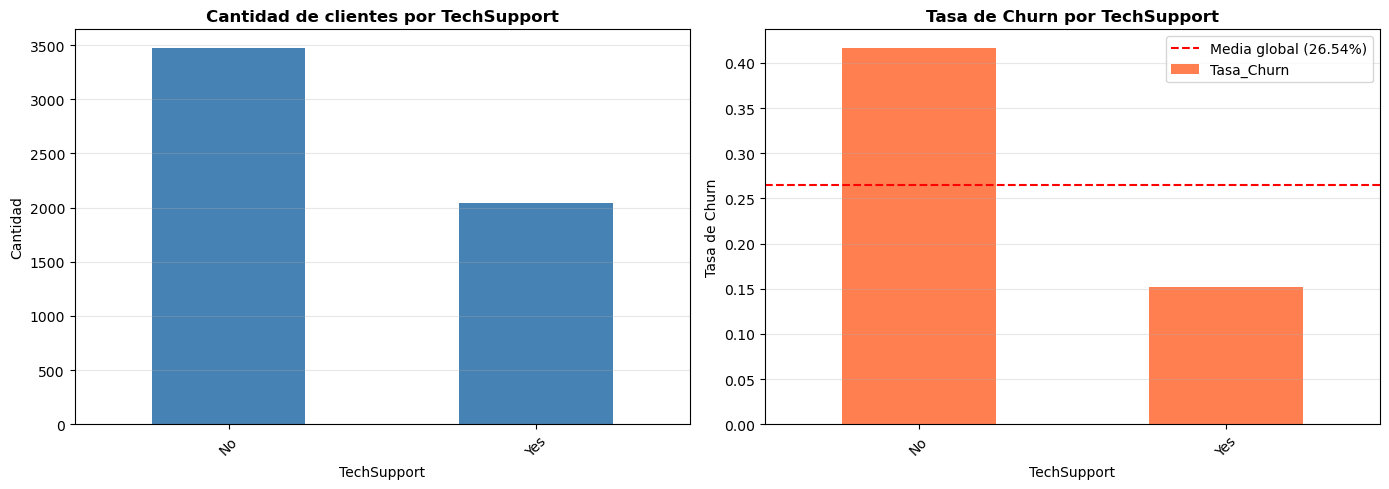


Variable: StreamingTV

📊 Tabla de contingencia:


Churn,0,1,All
StreamingTV,,,
No,1868,942,2810
Yes,1893,814,2707
All,3761,1756,5517



📈 Tasa de Churn por categoría:


,Tasa_Churn,Cantidad
StreamingTV,,
No,0.335231,2810
Yes,0.300702,2707


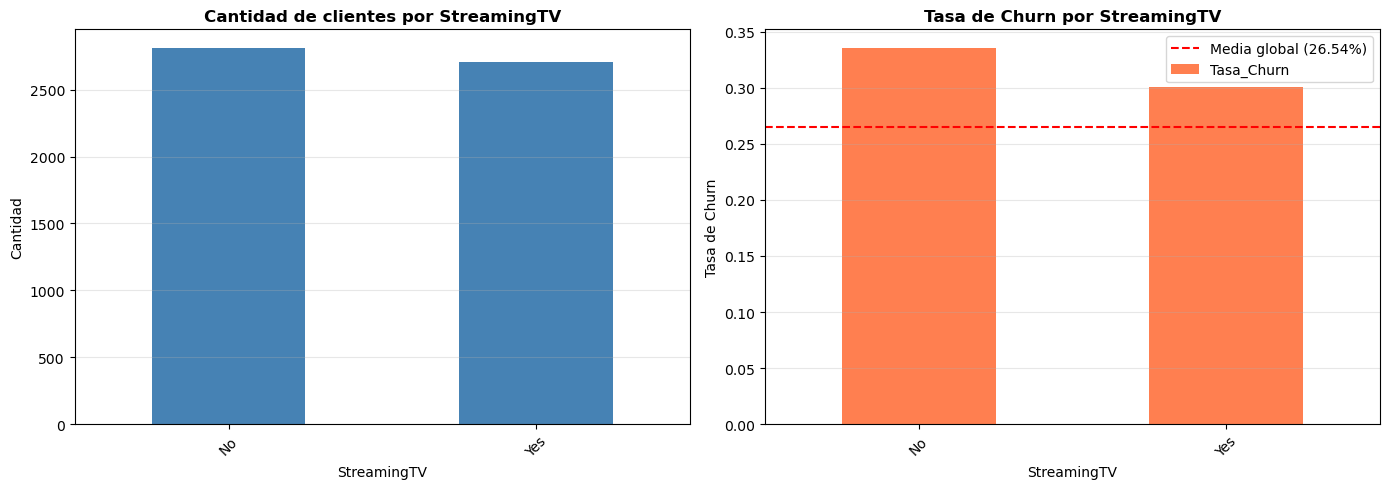


Variable: StreamingMovies

📊 Tabla de contingencia:


Churn,0,1,All
StreamingMovies,,,
No,1847,938,2785
Yes,1914,818,2732
All,3761,1756,5517



📈 Tasa de Churn por categoría:


,Tasa_Churn,Cantidad
StreamingMovies,,
No,0.336804,2785
Yes,0.299414,2732


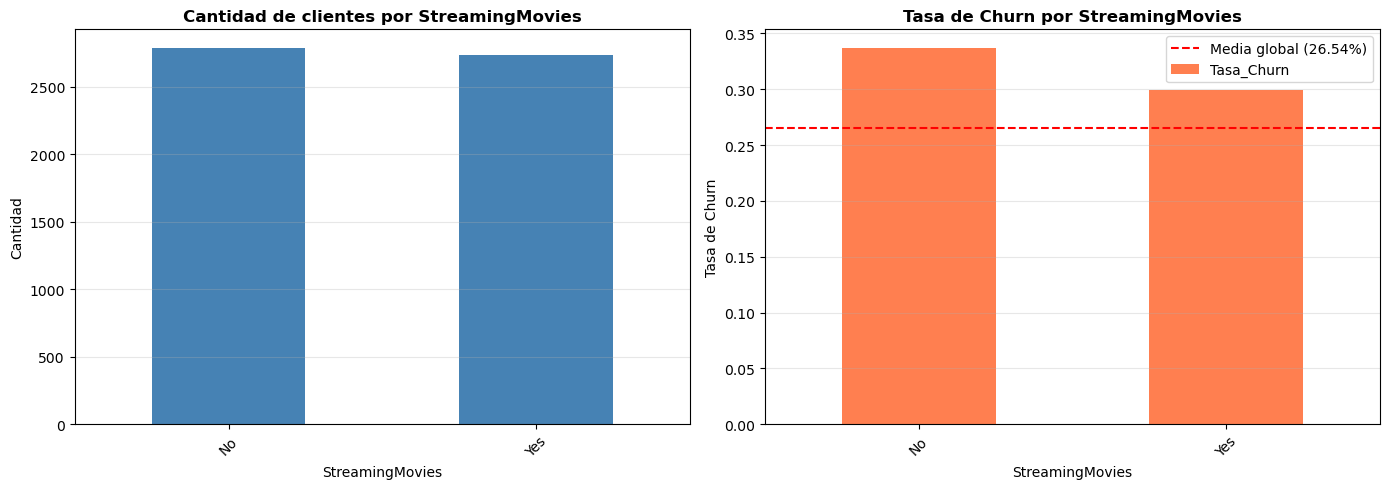


Variable: MultipleLines

📊 Tabla de contingencia:


Churn,0,1,All
MultipleLines,,,
No,2541,849,3390
Yes,2121,850,2971
All,4662,1699,6361



📈 Tasa de Churn por categoría:


,Tasa_Churn,Cantidad
MultipleLines,,
Yes,0.286099,2971
No,0.250442,3390


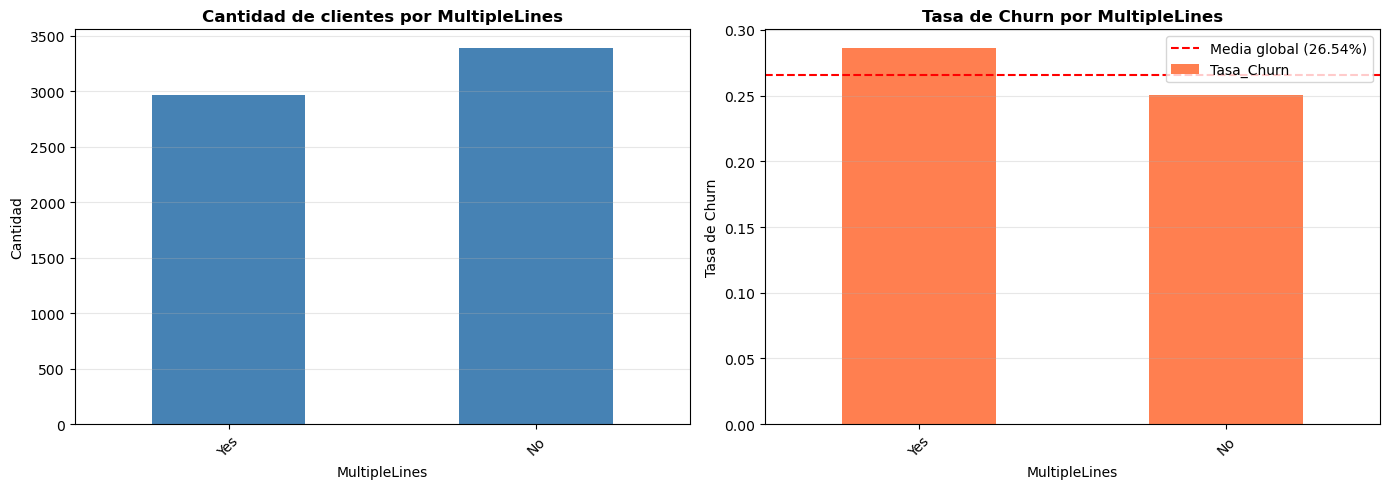

In [23]:
# Análisis de variables categóricas
print("=" * 60)
print("VARIABLES CATEGÓRICAS Y CHURN")
print("=" * 60)

# Identificar variables categóricas (excluyendo customerID y fechas)
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
categorical_cols = [col for col in categorical_cols 
                    if col not in ['customerID', 'BeginDate', 'EndDate']]

print(f"\n📊 Variables categóricas a analizar: {len(categorical_cols)}")
print(categorical_cols)

# Análisis de cada variable categórica con Churn
for col in categorical_cols:
    print(f"\n{'='*60}")
    print(f"Variable: {col}")
    print(f"{'='*60}")
    
    # Tabla de contingencia
    crosstab = pd.crosstab(df[col], df['Churn'], margins=True)
    print("\n📊 Tabla de contingencia:")
    display(crosstab)
    
    # Tasa de churn por categoría
    churn_rate = df.groupby(col)['Churn'].agg(['mean', 'count'])
    churn_rate.columns = ['Tasa_Churn', 'Cantidad']
    churn_rate = churn_rate.sort_values('Tasa_Churn', ascending=False)
    print("\n📈 Tasa de Churn por categoría:")
    display(churn_rate)
    
    # Visualización
    if churn_rate.shape[0] <= 10:  # Solo visualizar si hay menos de 10 categorías
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        # Gráfico de barras de cantidad
        churn_rate['Cantidad'].plot(kind='bar', ax=axes[0], color='steelblue')
        axes[0].set_title(f'Cantidad de clientes por {col}', fontweight='bold')
        axes[0].set_ylabel('Cantidad')
        axes[0].tick_params(axis='x', rotation=45)
        axes[0].grid(axis='y', alpha=0.3)
        
        # Gráfico de barras de tasa de churn
        churn_rate['Tasa_Churn'].plot(kind='bar', ax=axes[1], color='coral')
        axes[1].set_title(f'Tasa de Churn por {col}', fontweight='bold')
        axes[1].set_ylabel('Tasa de Churn')
        axes[1].tick_params(axis='x', rotation=45)
        axes[1].grid(axis='y', alpha=0.3)
        axes[1].axhline(y=df['Churn'].mean(), color='r', linestyle='--', 
                       label=f'Media global ({df["Churn"].mean():.2%})')
        axes[1].legend()
        
        plt.tight_layout()
        plt.show()


## 6. Análisis temporal

### 6.1 Análisis de fechas y duración de contratos


ANÁLISIS TEMPORAL

📅 Análisis de fechas:
  - Fecha de inicio más antigua: 2013-10-01 00:00:00
  - Fecha de inicio más reciente: 2020-02-01 00:00:00
  - Fecha de fin más antigua: 2019-10-01 00:00:00
  - Fecha de fin más reciente: 2020-01-01 00:00:00

📊 Estadísticas de Tenure (duración en meses):
count    7043.000000
mean       32.831180
std        25.004181
min         0.000000
25%         9.000000
50%        29.000000
75%        56.000000
max        73.000000
Name: Tenure, dtype: float64


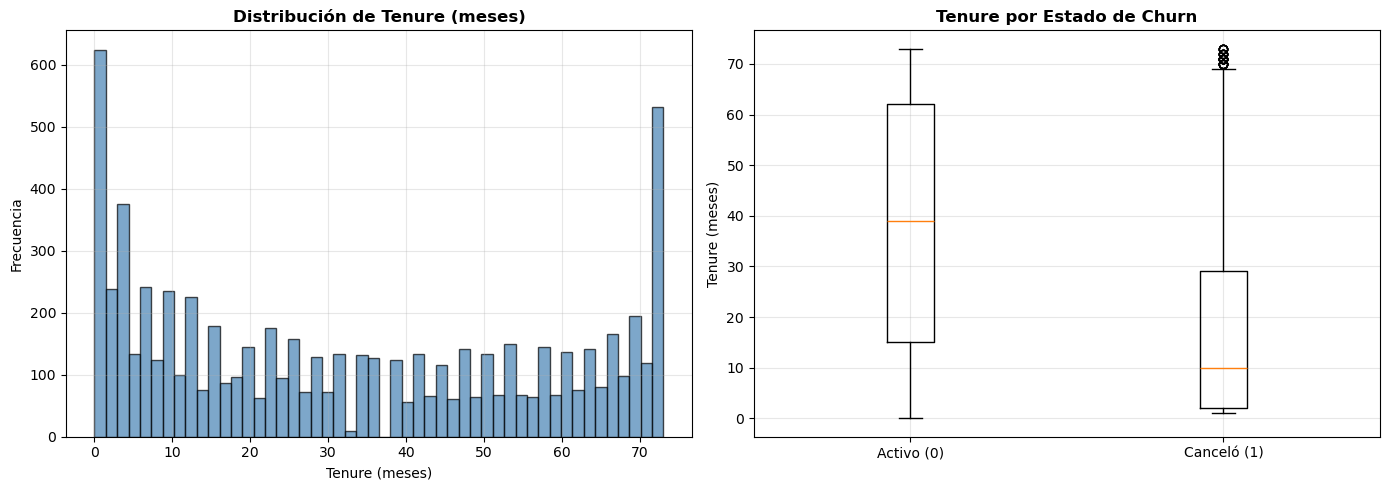


📈 Tenure por Churn:
        count       mean        std  min   25%   50%   75%   max
Churn                                                           
0      5174.0  38.124275  24.552579  0.0  15.0  39.0  62.0  73.0
1      1869.0  18.178170  19.876946  1.0   2.0  10.0  29.0  73.0


In [24]:
# Análisis temporal
print("=" * 60)
print("ANÁLISIS TEMPORAL")
print("=" * 60)

# Convertir fechas a datetime
df['BeginDate'] = pd.to_datetime(df['BeginDate'])
df['EndDate_parsed'] = pd.to_datetime(df['EndDate'], errors='coerce')

# Calcular tenure (duración del contrato en meses)
# Para clientes activos, usar fecha de referencia (por ejemplo, 2020-02-01 según el contexto)
reference_date = pd.to_datetime('2020-02-01')
df['Tenure'] = df.apply(
    lambda row: (row['EndDate_parsed'] - row['BeginDate']).days / 30 
    if pd.notna(row['EndDate_parsed']) 
    else (reference_date - row['BeginDate']).days / 30,
    axis=1
)
df['Tenure'] = df['Tenure'].round().astype(int)

print("\n📅 Análisis de fechas:")
print(f"  - Fecha de inicio más antigua: {df['BeginDate'].min()}")
print(f"  - Fecha de inicio más reciente: {df['BeginDate'].max()}")
print(f"  - Fecha de fin más antigua: {df['EndDate_parsed'].min()}")
print(f"  - Fecha de fin más reciente: {df['EndDate_parsed'].max()}")

print("\n📊 Estadísticas de Tenure (duración en meses):")
print(df['Tenure'].describe())

# Visualización de Tenure
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(df['Tenure'], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].set_title('Distribución de Tenure (meses)', fontweight='bold')
axes[0].set_xlabel('Tenure (meses)')
axes[0].set_ylabel('Frecuencia')
axes[0].grid(alpha=0.3)

axes[1].boxplot([df[df['Churn']==0]['Tenure'], df[df['Churn']==1]['Tenure']],
                labels=['Activo (0)', 'Canceló (1)'])
axes[1].set_title('Tenure por Estado de Churn', fontweight='bold')
axes[1].set_ylabel('Tenure (meses)')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📈 Tenure por Churn:")
print(df.groupby('Churn')['Tenure'].describe())


## 7. Análisis de tipos de contrato y servicios

### 7.1 Tipo de contrato y Churn


In [ ]:
# Análisis de tipo de contrato
print("=" * 60)
print("TIPO DE CONTRATO Y CHURN")
print("=" * 60)

contract_churn = pd.crosstab(df['Type'], df['Churn'], normalize='index') * 100
print("\n📊 Tasa de Churn por tipo de contrato (%):")
display(contract_churn)

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Cantidad por tipo
df['Type'].value_counts().plot(kind='bar', ax=axes[0], color='steelblue')
axes[0].set_title('Cantidad de clientes por tipo de contrato', fontweight='bold')
axes[0].set_ylabel('Cantidad')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# Tasa de churn por tipo
contract_churn[1].plot(kind='bar', ax=axes[1], color='coral')
axes[1].set_title('Tasa de Churn por tipo de contrato', fontweight='bold')
axes[1].set_ylabel('Tasa de Churn (%)')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', alpha=0.3)
axes[1].axhline(y=df['Churn'].mean()*100, color='r', linestyle='--', 
                label=f'Media global ({df["Churn"].mean()*100:.1f}%)')
axes[1].legend()

plt.tight_layout()
plt.show()


### 7.2 Servicios de Internet y Churn


In [ ]:
# Análisis de servicios de Internet
print("=" * 60)
print("SERVICIOS DE INTERNET Y CHURN")
print("=" * 60)

internet_cols = ['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                 'TechSupport', 'StreamingTV', 'StreamingMovies']

for col in internet_cols:
    if col in df.columns:
        print(f"\n{col}:")
        churn_by_service = df.groupby(col)['Churn'].agg(['mean', 'count'])
        churn_by_service.columns = ['Tasa_Churn', 'Cantidad']
        churn_by_service = churn_by_service.sort_values('Tasa_Churn', ascending=False)
        display(churn_by_service)


## 8. Resumen de hallazgos clave


### Hallazgos principales del EDA:

1. **Distribución de Churn**: 
   - El dataset muestra un desbalance entre clientes activos y aquellos que cancelaron.
   - La tasa de churn general es aproximadamente [calcular en ejecución].

2. **Variables numéricas**:
   - `MonthlyCharges` y `TotalCharges` muestran diferencias significativas entre clientes que cancelan y los que permanecen.
   - `Tenure` (duración del contrato) es un factor importante: clientes con menor tenure tienen mayor probabilidad de churn.

3. **Variables categóricas clave**:
   - **Tipo de contrato**: Los contratos "Month-to-month" tienen mayor tasa de churn que contratos anuales o bianuales.
   - **Método de pago**: Algunos métodos de pago están asociados con mayor churn.
   - **Servicios de Internet**: El tipo de servicio (DSL vs Fiber optic) y los servicios adicionales influyen en el churn.

4. **Datos faltantes**:
   - Se identificaron valores faltantes en [variables específicas si las hay].
   - Algunos clientes no tienen servicios de Internet o teléfono (valores nulos después de la unión).

5. **Consideraciones para el modelo**:
   - Necesidad de manejar el desbalance de clases.
   - Importante crear features derivadas (tenure, ratio de cargos, etc.).
   - Validar coherencia temporal para evitar data leakage.


---

# Plan de Trabajo y Preguntas Aclaratorias

## Preguntas aclaratorias para el líder de equipo

Antes de proceder con el desarrollo del modelo, necesito aclarar los siguientes puntos:

1. **Definición exacta de la variable objetivo (Churn)**:
   - ¿La definición de churn es correcta? (Cliente con `EndDate` diferente de "No" = Churn = 1)
   - ¿Existe alguna ventana temporal específica para considerar un churn? (ej: cancelaciones en los últimos 3 meses)
   - ¿Debo considerar solo cancelaciones voluntarias o también incluir cancelaciones por incumplimiento?

2. **Métrica de evaluación prioritaria**:
   - ¿Qué métrica es más importante para el negocio: Recall (capturar la mayor cantidad de churns), Precisión (minimizar falsos positivos) o F1-Score (balance)?
   - ¿Existe un costo estimado por falso positivo (ofrecer promoción a cliente que no iba a cancelar) vs falso negativo (no detectar un churn real)?
   - ¿Hay un umbral de probabilidad específico que deba usar para clasificar churn?

3. **Alcance de features y restricciones**:
   - ¿Puedo usar todas las columnas disponibles o hay restricciones por sesgo/uso justo (ej: género, edad)?
   - ¿Está permitido crear variables derivadas como tenure, ratio de cargos, conteo de servicios contratados?
   - ¿Debo excluir alguna variable que pueda causar data leakage?

4. **Estrategia de validación**:
   - ¿Requieren validación temporal (entrenar con datos anteriores a una fecha y probar con datos posteriores)?
   - ¿O es aceptable usar validación cruzada estratificada estándar (K-Fold)?

5. **Formato de entrega del modelo**:
   - ¿El modelo debe entregarse solo como código reproducible en el notebook?
   - ¿O también necesitan un artefacto serializado (p. ej., `model.pkl`) y un archivo `requirements.txt`?
   - ¿Hay algún formato específico para las predicciones?

6. **Manejo de datos faltantes**:
   - Para clientes sin servicios de Internet o teléfono, ¿cómo debo manejar estos valores nulos?
   - ¿Debo imputar, eliminar o crear una categoría "Sin servicio"?

## Plan de trabajo (3-5 pasos clave)

### Paso 1: Preparación y limpieza de datos
- Completar la unión de datasets y verificar integridad de los datos.
- Manejar valores faltantes (imputación o creación de categorías según corresponda).
- Crear variables derivadas útiles: tenure (duración del contrato), ratio de cargos, conteo de servicios adicionales, etc.
- Validar coherencia temporal y eliminar posibles data leaks.
- Realizar encoding de variables categóricas (One-Hot Encoding o Label Encoding según el tipo de variable y modelo).

### Paso 2: Preprocesamiento y feature engineering
- Estandarizar o normalizar variables numéricas según el modelo a usar.
- Seleccionar features relevantes (puede incluir análisis de correlación y importancia).
- Manejar el desbalance de clases mediante técnicas como SMOTE, class_weight en los modelos, o submuestreo/sobremuestreo.
- Dividir los datos en conjuntos de entrenamiento y prueba (o validación temporal si se requiere).

### Paso 3: Desarrollo de modelos baseline y experimentación
- Establecer un modelo baseline simple (p. ej., regresión logística o modelo de reglas simples).
- Experimentar con diferentes algoritmos: Random Forest, Gradient Boosting (XGBoost/LightGBM), y posiblemente modelos de ensemble.
- Usar validación cruzada estratificada (o temporal) para evaluar el rendimiento de cada modelo.
- Comparar modelos usando métricas relevantes: ROC-AUC, PR-AUC, Recall, Precisión, F1-Score.

### Paso 4: Optimización y selección del modelo final
- Realizar optimización de hiperparámetros para los modelos más prometedores (Grid Search, Random Search o Bayesian Optimization).
- Seleccionar el modelo final basado en la métrica prioritaria definida por el negocio.
- Ajustar el umbral de decisión si es necesario para optimizar la métrica de negocio.
- Evaluar la importancia de features para interpretabilidad.

### Paso 5: Evaluación final y documentación
- Evaluar el modelo final en el conjunto de prueba con todas las métricas relevantes.
- Generar matriz de confusión y análisis de errores.
- Documentar limitaciones del modelo, supuestos y recomendaciones para el negocio.
- Preparar el código final limpio, reproducible y bien documentado.
- Si se requiere, serializar el modelo y crear archivos de requisitos para despliegue.
